In [1]:
# Install all the required packages
%pip install pandas
%pip install matplotlib
%pip install numpy
%pip install scikit-learn
%pip install openpyxl
%pip install torch
%pip install keras
%pip install tensorflow-directml
%pip install tensorflow

You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


  Using cached matplotlib-3.5.3-cp37-cp37m-win_amd64.whl (7.2 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: matplotlib 3.5.3 requires cycler>=0.10, which is not installed.
ERROR: matplotlib 3.5.3 requires pillow>=6.2.0, which is not installed.
ERROR: matplotlib 3.5.3 requires pyparsing>=2.2.1, which is not installed.
You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


  Using cached scikit_learn-1.0.2-cp37-cp37m-win_amd64.whl (7.1 MB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [7]:
%pip install torch


Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [8]:
%pip install keras

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [13]:
%pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached libclang-16.0.6-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached google_auth-2.27.0-py2.py3-none-any.whl (186 kB)
  Using cached requests-2.31.0-py3-none-any.whl (62 kB)
  Using cached cachetools-5.3.2-py3-none-any.whl (9.3 kB)
  Using cached rsa-4.9-py3-none-any.whl (34 kB)
  Using cached pyasn1_modules-0.3.0-py2.py3-none-any.whl (181 kB)
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached idna-3.6-py3-none-any.whl (61 kB)
  Using cached certifi-2023.11.17-py3-none-any.whl (162 kB)
  Using cached pyasn1-0.5.1-py2.py3-none-any.whl (84 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
Note: you may need to restart the kernel to use updated packag

ERROR: tensorflow-directml 1.15.8 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.21.6 which is incompatible.
ERROR: tensorflow-directml 1.15.8 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.11.2 which is incompatible.
ERROR: tensorflow-directml 1.15.8 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.11.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\users\\user\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp37-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\Users\User\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


In [5]:
# Code to allow GPU access
import tensorflow.compat.v1 as tf 
tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True)) 
tf.test.gpu_device_name()

'/device:DML:0'

In [3]:
'''LOADING DATA FROM FILES'''

import pandas as pd
import os

# Load label file
label_df = pd.read_excel('../Data/wax/data labels anna - simple.xlsx')
# clean up column names
label_df.columns = ['code', 'month', 'ID', 'optimality', 'abnormal', 'AIMS']
print(label_df.head())

# Cleanup data, remove rows where AIMS score is 999
#cleaned_label_df = label_df[label_df.AIMS != 999]


   code  month   ID  optimality  abnormal  AIMS
0  1023      0  180           9       1.0     1
1  1023      1  195          14       1.0   999
2  1023      2  197          26       1.0     1
3  1023      3  206          11       1.0     2
4  1023      4  208          13       1.0     1


processing instance 0
File not found for instance 0
processing instance 1
processing instance 2
File not found for instance 2
processing instance 3
File not found for instance 3
processing instance 4
File not found for instance 4
processing instance 5
File not found for instance 5
processing instance 6
File not found for instance 6
processing instance 7
processing instance 8
processing instance 9
processing instance 10
processing instance 11
File not found for instance 11
processing instance 12
processing instance 13
processing instance 14
Error processing instance 14
Error Empty dataframe
processing instance 15
processing instance 16
processing instance 17
File not found for instance 17
processing instance 18
File not found for instance 18
processing instance 19
processing instance 20
processing instance 21
processing instance 22
File not found for instance 22
processing instance 23
File not found for instance 23
processing instance 24
processing instance 25
processing instance 26
pro

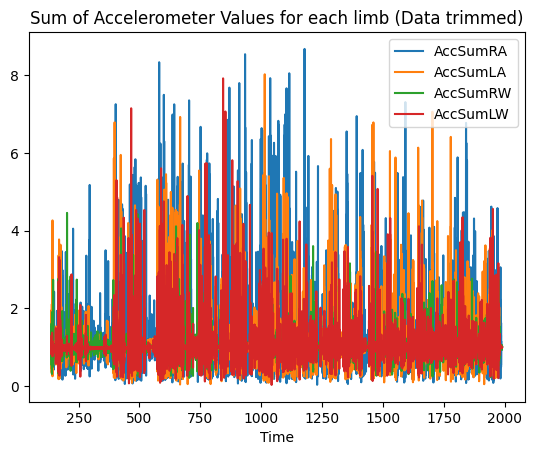

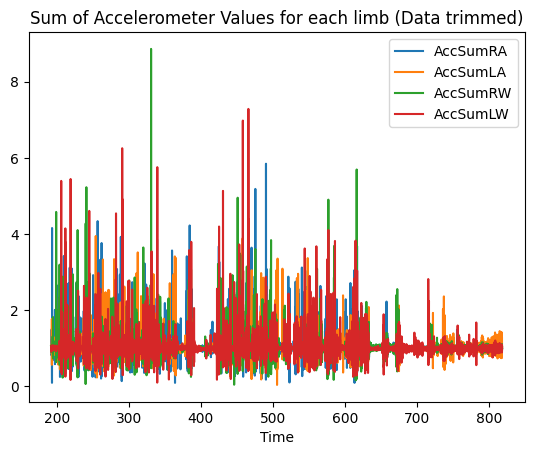

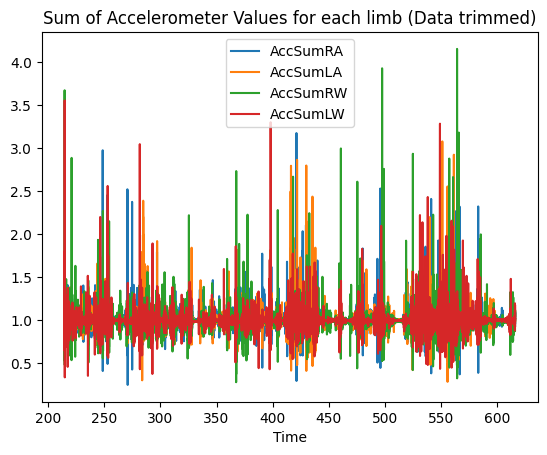

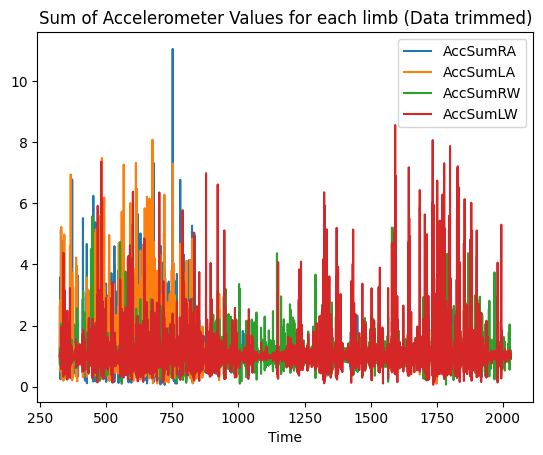

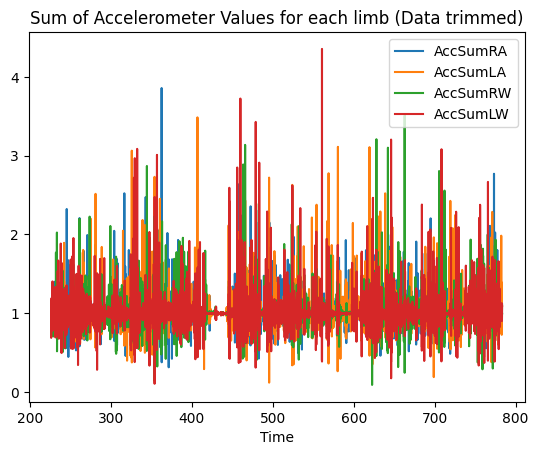

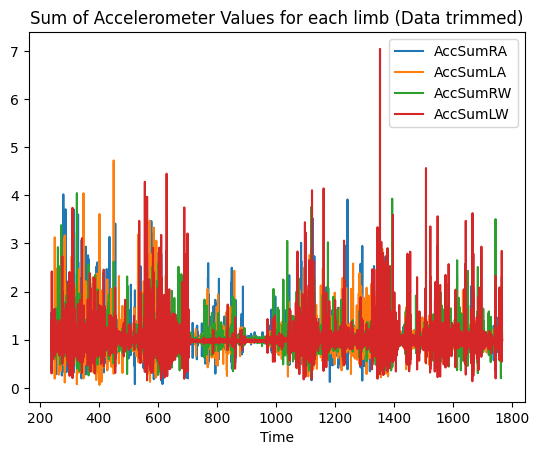

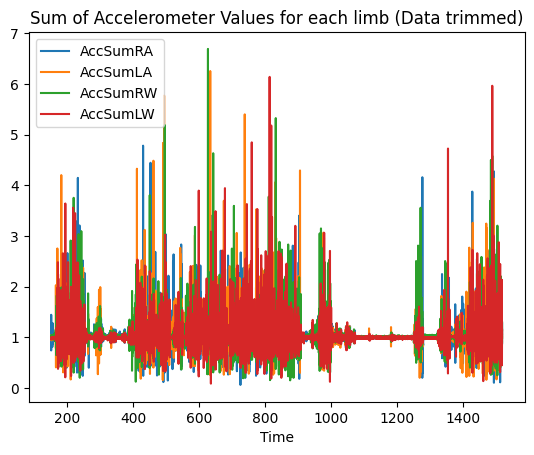

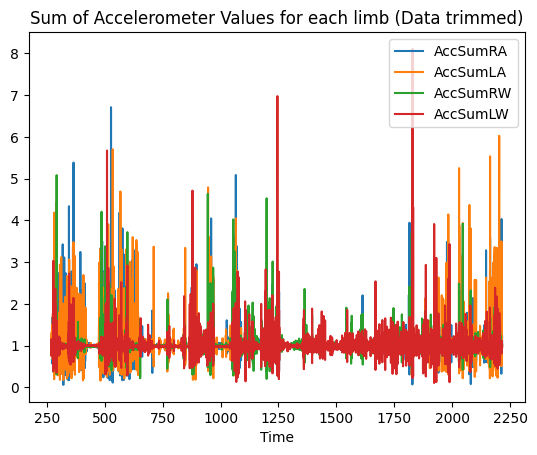

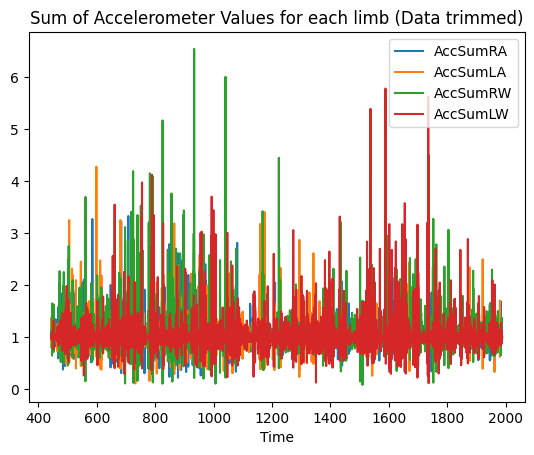

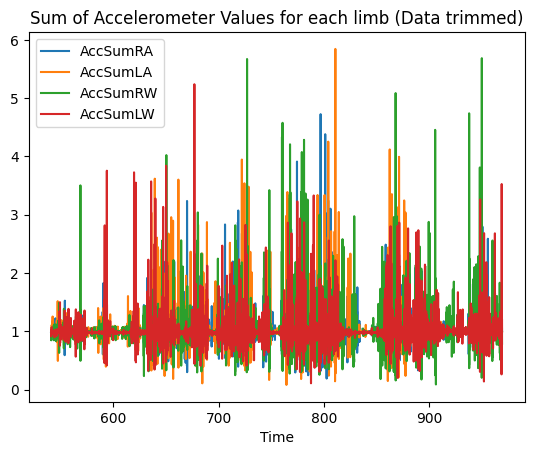

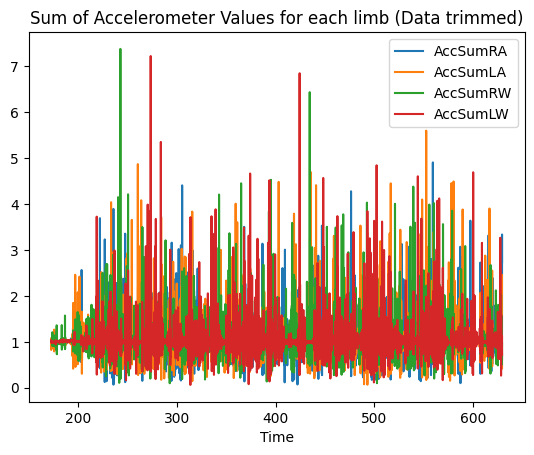

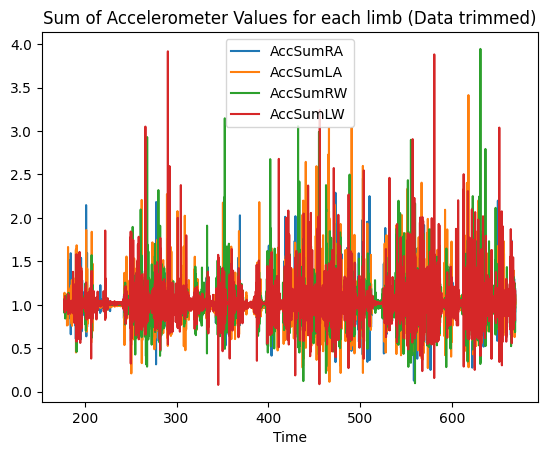

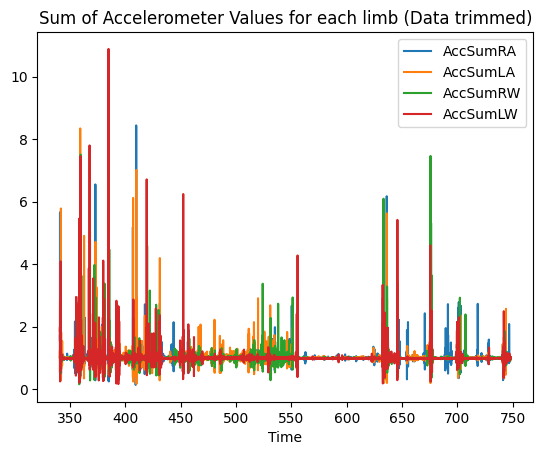

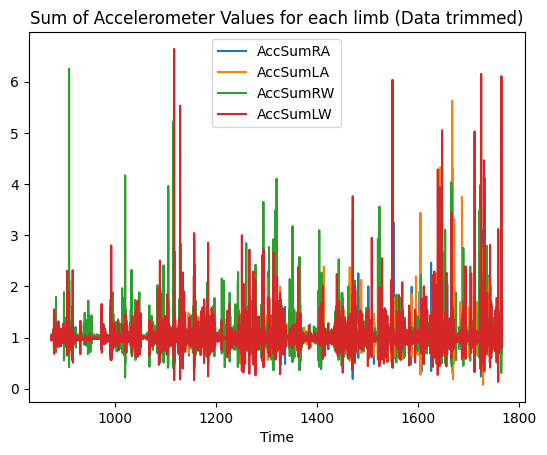

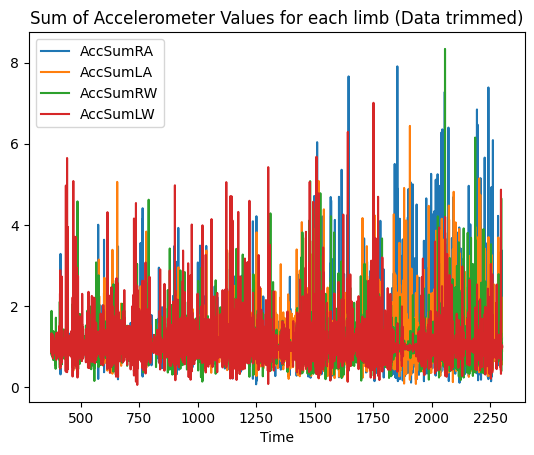

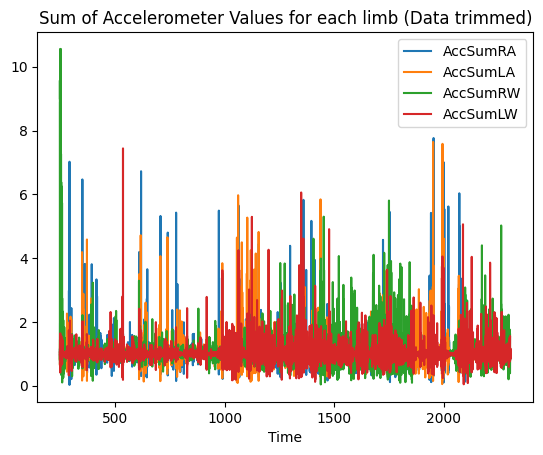

In [4]:
'''LOADING SENSOR DATA INTO DATAFRAMES and TRIMMING TRIALS'''

import matplotlib.pyplot as plt
import numpy as np

def load_sensor_data(trial_folder, sensor):
    df = pd.read_csv(trial_folder + "/" + sensor + ".csv")
    df = df[(df.T != 0).any()]
    return df

'''def truncate_df(df, min_rows):
    return df[:min_rows]'''

def combine_dfs(dfs):
    return pd.concat(dfs, axis=1)

def process_df(df, min_rows):
    # Drop rows where all entries are zero
    df = df[(df.T != 0).any()]
    # Truncate dataframe to min_rows
    df = df[:min_rows]
    return df

def rename_columns(df):
    df.columns = ['Time', 'AccXRA', 'AccYRA', 'AccZRA', 'GyrXRA', 'GyrYRA', 'GyrZRA', 'MagXRA', 'MagYRA', 'MagZRA',
                  'AccXLA', 'AccYLA', 'AccZLA', 'GyrXLA', 'GyrYLA', 'GyrZLA', 'MagXLA', 'MagYLA', 'MagZLA',
                  'AccXRW', 'AccYRW', 'AccZRW', 'GyrXRW', 'GyrYRW', 'GyrZRW', 'MagXRW', 'MagYRW', 'MagZRW',
                  'AccXLW', 'AccYLW', 'AccZLW', 'GyrXLW', 'GyrYLW', 'GyrZLW', 'MagXLW', 'MagYLW', 'MagZLW']
    return df

def calculate_acceleration_sums(df):
    df['AccSumRA'] = np.sqrt(df['AccXRA']**2 + df['AccYRA']**2 + df['AccZRA']**2)
    df['AccSumLA'] = np.sqrt(df['AccXLA']**2 + df['AccYLA']**2 + df['AccZLA']**2)
    df['AccSumRW'] = np.sqrt(df['AccXRW']**2 + df['AccYRW']**2 + df['AccZRW']**2)
    df['AccSumLW'] = np.sqrt(df['AccXLW']**2 + df['AccYLW']**2 + df['AccZLW']**2)
    df['AccSumSumR'] = df['AccSumRA'] + df['AccSumRW']+ df['AccSumLA'] + df['AccSumLW']
    return df

def calculate_rolling_mean(df, window_size):
    df['AccSumSumR_Rolling10000'] = df['AccSumSumR'].rolling(window_size).mean()
    return df

def trim_df(df, start_index, end_index):
    return df.iloc[start_index:end_index-10000]

def drop_columns(df, columns):
    df.drop(columns=columns, inplace=True)
    return df

def calculate_peak_indices(first_half, second_half, column_name):
    start_peak_index = first_half[column_name].idxmax() + 10000
    end_peak_index = second_half[column_name].idxmax() - 10000
    return start_peak_index, end_peak_index

def process_trial(index, row, label_df):

    print("processing instance", index)
    trial_id = row["ID"]
    infant_id = row["code"]
    if trial_id < 10:
        addedZero = '00'
    elif row['ID'] < 100:
        addedZero = '0'
    else:
        addedZero = ''

    trial_folder = '../Data/wax/p' + addedZero + str(trial_id)

    ra_df = load_sensor_data(trial_folder, "RA")
    la_df = load_sensor_data(trial_folder, "LA")
    rw_df = load_sensor_data(trial_folder, "RW")
    lw_df = load_sensor_data(trial_folder, "LW")

    # Get the minimum number of rows across all dataframes
    min_rows = min(ra_df.shape[0], la_df.shape[0], rw_df.shape[0], lw_df.shape[0])  

    #Process each dataframe
    ra_df = process_df(ra_df, min_rows)
    la_df = process_df(la_df, min_rows)
    rw_df = process_df(rw_df, min_rows)
    lw_df = process_df(lw_df, min_rows)

    # Remove first column from la, rw, lw dfs using indexing
    la_df = la_df.iloc[:, 1:]
    rw_df = rw_df.iloc[:, 1:]
    lw_df = lw_df.iloc[:, 1:]

    combined_df = combine_dfs([ra_df, la_df, rw_df, lw_df])
    combined_df = rename_columns(combined_df)
    combined_df = calculate_acceleration_sums(combined_df)

    # Split df in half
    first_half = combined_df.iloc[0:combined_df.shape[0]//2]
    second_half = combined_df.iloc[combined_df.shape[0]//2:combined_df.shape[0]]
   
    ra_start_peak_index, ra_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumRA')
    la_start_peak_index, la_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumLA')
    rw_start_peak_index, rw_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumRW')
    lw_start_peak_index, lw_end_peak_index = calculate_peak_indices(first_half, second_half, 'AccSumLW')

    starts = [ra_start_peak_index, la_start_peak_index, rw_start_peak_index, lw_start_peak_index]
    ends = [ra_end_peak_index, la_end_peak_index, rw_end_peak_index, lw_end_peak_index]

    max_end = max(ends)
    max_index = ends.index(max_end)
    max_start = starts[max_index]
    difference = max_end - max_start

    ra_df_trimmed = trim_df(ra_df, ra_start_peak_index, ra_start_peak_index + difference)
    la_df_trimmed = trim_df(la_df, la_start_peak_index, la_start_peak_index + difference)
    rw_df_trimmed = trim_df(rw_df, rw_start_peak_index, rw_start_peak_index + difference)
    lw_df_trimmed = trim_df(lw_df, lw_start_peak_index, lw_start_peak_index + difference) 
    
    # Reset the index of each df
    ra_df_trimmed = ra_df_trimmed.reset_index(drop=True)
    la_df_trimmed = la_df_trimmed.reset_index(drop=True)
    rw_df_trimmed = rw_df_trimmed.reset_index(drop=True)
    lw_df_trimmed = lw_df_trimmed.reset_index(drop=True)

    trimmed_df = combine_dfs([ra_df_trimmed, la_df_trimmed, rw_df_trimmed, lw_df_trimmed])
    trimmed_df = rename_columns(trimmed_df)
    trimmed_df = calculate_acceleration_sums(trimmed_df)

    # Plot trimmed_df for every 10 instances (sanity check)
    if index % 10 == 0:
        trimmed_df.plot(x='Time', y=['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW'], title='Sum of Accelerometer Values for each limb (Data trimmed)')
    trimmed_df = drop_columns(trimmed_df, ['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW', 'AccSumSumR'])

    # If trimmed_df is empty, raise an exception. Prevents empty dataframes from being added to the list
    if trimmed_df.empty:
        raise Exception("Empty dataframe")

    return trimmed_df, row['month'], row['code'], row['abnormal'], row['AIMS'], row['optimality']

sensorX = [] # List of dataframes (just the sensor data)
accelX = [] # List of dataframes (just the accelerometer data)
combinedX = [] # Sensor data, infant ID, infant age
abnormalY = [] # Abnormal / Normal
aimsY = [] # AIMS score
optimalityY = [] # Optimality score

for index, row in label_df.iterrows():
    try:
        combined_df_trimmed, month, code, abnormal, aims, optimality = process_trial(index, row, label_df)

        # Add all sensor data to sensorX
        sensorX.append(combined_df_trimmed)

        # Add all sensor data, infant ID, infant age to combinedX
        combinedX.append([combined_df_trimmed, month, code])

        # Add just accelerometer data to accelX
        combined_df_trimmed_copy = combined_df_trimmed.copy()
        combined_df_trimmed_copy = drop_columns(combined_df_trimmed_copy, ['MagXRA', 'MagYRA', 'MagZRA', 
                                                                           'MagXLA', 'MagYLA', 'MagZLA', 
                                                                           'MagXRW', 'MagYRW', 'MagZRW', 
                                                                           'MagXLW', 'MagYLW', 'MagZLW']) # drop magnetometer data
        combined_df_trimmed_copy = drop_columns(combined_df_trimmed_copy, ['GyrXRA', 'GyrYRA', 'GyrZRA', 
                                                                           'GyrXLA', 'GyrYLA', 'GyrZLA', 
                                                                           'GyrXRW', 'GyrYRW', 'GyrZRW', 
                                                                           'GyrXLW', 'GyrYLW', 'GyrZLW']) # drop gyroscope data    
        accelX.append(combined_df_trimmed_copy)
        
        # Add abnormality label to abnormalY
        abnormalY.append(abnormal)

        # Add AIMS score to aimsY
        aimsY.append(aims)

        # Add optimality score to optimalityY
        optimalityY.append(optimality)

    except FileNotFoundError:
        print("File not found for instance", index)

    except Exception as e:
        print("Error processing instance", index)
        print("Error", e)   

# Sanity check: Print results
print("Sensor X:")
print(sensorX[0])
print("Combined X:")
print(combinedX[0])
print("Accel X:")
print(accelX[0])
print("Labels")
print(abnormalY)
print(aimsY)
print(optimalityY)

In [9]:
'''SCALING ACCELEROMETER DATA'''

# Make each dataframe the same length in accelX
# Find the minimum length
min_length = min([df.shape[0] for df in accelX])
print("Minimum length:", min_length)

# Truncate each dataframe to the minimum length
accelX_clean = [df[:min_length] for df in accelX]

# Convert accelX to a numpy array
accelX_clean = np.array([df.values for df in accelX_clean])

# Convert accelX to a tensor
#%pip install torch
import torch
accelX_clean = torch.Tensor(accelX_clean)

print("Accel X shape:", accelX_clean.shape)

# Normalise accelX
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
accelX_scaled = scaler.fit_transform(accelX_clean.reshape(-1, accelX_clean.shape[-1])).reshape(accelX_clean.shape)

print("Accel X shape:", accelX_scaled.shape)
print(accelX_scaled[0])


Minimum length: 10885
Accel X shape: torch.Size([147, 10885, 13])
Accel X shape: (147, 10885, 13)
[[0.12872135 0.54798972 0.45170792 ... 0.50778235 0.52340361 0.46624708]
 [0.12873141 0.54851946 0.45184263 ... 0.5078436  0.52326882 0.46637669]
 [0.12874148 0.54851946 0.45184263 ... 0.5078436  0.52326882 0.46637669]
 ...
 [0.23831729 0.49917251 0.39888588 ... 0.50369272 0.515076   0.59781907]
 [0.23832734 0.4989073  0.39935599 ... 0.50369272 0.51514339 0.59840332]
 [0.23833742 0.49884082 0.39969139 ... 0.50222826 0.51447223 0.59840332]]


In [33]:
'''CREATE TEST AND TRAINING SETS'''

# X dataset : accelX_scaled
# Y dataset : abnormalY

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(accelX_scaled, abnormalY, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", len(Y_train))
print("Y_test shape:", len(Y_test))

# Make Y_train and Y_test numpy arrays
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)


X_train shape: (117, 10885, 13)
X_test shape: (30, 10885, 13)
Y_train shape: 117
Y_test shape: 30


In [16]:
# Save test and train sets to files. To possibly be used in other notebooks.
torch.save(X_train, '../Data/wax/trainAndTest/X_train.pt')
torch.save(X_test, '../Data/wax/trainAndTest/X_test.pt')
torch.save(Y_train, '../Data/wax/trainAndTest/Y_train.pt')
torch.save(Y_test, '../Data/wax/trainAndTest/Y_test.pt')


In [71]:
# Create simple keras model
# Model description: 2 hidden layers, 64 nodes in each hidden layer, relu activation function
# Optimizer: adam
# Loss function: binary crossentropy
# Metrics: accuracy
tf.keras.backend.clear_session()

with tf.device('/device:DML:0'):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(10885, 13)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation='sigmoid')
    ])


    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])   

    print(type(X_train))
    print(type(Y_train))

    model.fit(X_train, Y_train, epochs=10, batch_size=32)

    # Test model
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    tf.keras.backend.clear_session()

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:DML:0 in order to run LogicalNot: OOM when closing the command list [Op:LogicalNot]

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pack in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_5130 in device /job:localhost/replica:0/task:0/device:DM

In [36]:
# Build more sophisticated model.
# Deep learning based this time (CNN)
# Model description: 2 convolutional layers, 2 max pooling layers, 2 dense layers
# Optimizer: adam
# Loss function: binary crossentropy
# Metrics: accuracy

with tf.device('/device:DML:0'):

    model = keras.Sequential([
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10885, 13)),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])   

    print(type(X_train))
    print(type(Y_train))

    model.fit(X_train, Y_train, epochs=10, batch_size=32)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

In [37]:
with tf.device('/device:DML:0'):

    model = keras.Sequential([
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10885, 13)),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Dropout(0.2),
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])   

    print(type(X_train))
    print(type(Y_train))

    model.fit(X_train, Y_train, epochs=10, batch_size=32)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/devic

In [64]:
from tensorflow.compat.v1.keras.utils import to_categorical

# One hot encoding of Y_train and Y_test

Y_train_encoded = to_categorical(Y_train, num_classes=3)
Y_test_encoded = to_categorical(Y_test, num_classes=3)

In [42]:
print(Y_train_encoded)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0.

In [45]:

with tf.device('/device:DML:0'):

    model = keras.Sequential([
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10885, 13)),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Dropout(0.2),
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])   

    print(type(X_train))
    print(type(Y_train_encoded))

    model.fit(X_train, Y_train_encoded, epochs=100, batch_size=32)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exec

In [48]:
# Test model
test_loss, test_acc = model.evaluate(X_test, Y_test_encoded, verbose=2)
print('\nTest accuracy:', test_acc)


Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_15140 in device /job:localhost/replica:0/task:0/device:DML:0
30/1 - 0s - loss: 0.6450 - acc: 0.6667

Test accuracy: 0.6666666


In [61]:
with tf.device('/device:DML:0'):

    model = keras.Sequential([
        keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(10885, 13)),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Dropout(0.2),
        keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Dropout(0.2),
        keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        keras.layers.MaxPooling1D(pool_size=2),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])   

    print(type(X_train))
    print(type(Y_train_encoded))

    model.fit(X_train, Y_train_encoded, epochs=20, batch_size=32)

    # Test model
    test_loss, test_acc = model.evaluate(X_test, Y_test_encoded, verbose=2)

    print('\nTest accuracy:', test_acc)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Exec

In [62]:
# Implement LSTM model
# Model description: 2 LSTM layers, 2 dense layers
# Optimizer: adam
# Loss function: binary crossentropy
# Metrics: accuracy

with tf.device('/device:DML:0'):
    model = keras.Sequential([
        keras.layers.LSTM(64, input_shape=(10885, 13), return_sequences=True),
        keras.layers.LSTM(64),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])   

    print(type(X_train))
    print(type(Y_train))

    model.fit(X_train, Y_train, epochs=10, batch_size=32)

    # Test model
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op RandomStandardNormal in device /job:localhost/replica:0/task:0/device:DML:0
Executing op Qr in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op DiagPart in device /job:localhost/replica:0/task:0/device:DML:0
Executing op Sign in device /job:localhost/replica:0/task:0/device:DML:0
Executing op Transpose in device /job:localhost/replica:0/task:0/device:DML:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:DML:0
Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:DML:0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing o

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when closing the command list
	 [[{{node Func/sequential_20/lstm/while/body/_1/input/_1184/_28}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[sequential_20/lstm/while_grad/LoopCond/_955/_80]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when closing the command list
	 [[{{node Func/sequential_20/lstm/while/body/_1/input/_1184/_28}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_distributed_function_27509]

Function call stack:
distributed_function -> distributed_function


In [63]:
with tf.device('/device:DML:0'):
    model = keras.Sequential([
        keras.layers.LSTM(32, input_shape=(10885, 13), return_sequences=True),
        keras.layers.LSTM(32),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])   

    print(type(X_train))
    print(type(Y_train))

    model.fit(X_train, Y_train, epochs=10, batch_size=16)

    # Test model
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    tf.keras.backend.clear_session()

RuntimeError: OOM when closing the command list

In [66]:
tf.keras.backend.clear_session()